# SVM with linear kernel

The goal of this notebook is to find the best parameters for linear kernel. We also want to check if the parameters depend on stock.

Linear kernel is a function: $\langle x, x'\rangle$.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['9058', '13003', '9061', '9074', '11244', '9270', '9064']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 9058: 9332
Testing set length for 9058: 3110
Cross-validation set length for 9058: 3110
Training set length for 13003: 7755
Testing set length for 13003: 2584
Cross-validation set length for 13003: 2584
Training set length for 9061: 10347
Testing set length for 9061: 3449
Cross-validation set length for 9061: 3449
Training set length for 9074: 8596
Testing set length for 9074: 2864
Cross-validation set length for 9074: 2864
Training set length for 11244: 10512
Testing set length for 11244: 3503
Cross-validation set length for 11244: 3503
Training set length for 9270: 8385
Testing set length for 9270: 2795
Cross-validation set length for 9270: 2795
Training set length for 9064: 10606
Testing set length for 9064: 3535
Cross-validation set length for 9064: 3535


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
3110,2013-09-16 14:02:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 4920.0), (1917.5, 9151.0), (1918.0, ...",1916.0,1917.0,1916.50,4920.0,4181.0,1.0,-0.081200
3111,2013-09-16 14:03:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 1378.0), (1917.5, 6515.0), (1918.0, ...",1916.5,1917.0,1916.75,1378.0,96.0,0.0,-0.869742
3112,2013-09-16 14:04:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1916.5, 2428.0), (1917.0, 7498.0), (1917.5, ...",1915.5,1916.5,1916.00,2428.0,3568.0,1.0,0.190127
3113,2013-09-16 14:05:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1916.5, 900.0), (1917.0, 5990.0), (1917.5, 8...",1916.0,1916.5,1916.25,900.0,3648.0,1.0,0.604222
3114,2013-09-16 14:06:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 2012.0), (1917.5, 9613.0), (1918.0, ...",1916.0,1917.0,1916.50,2012.0,5083.0,1.0,0.432840


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults. For the **linear** kernel according to documentation it's worth to check only the **C** parameter.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

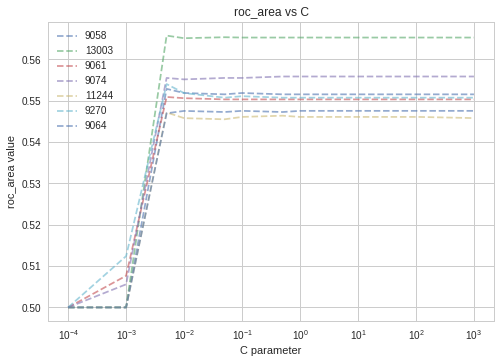

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100, 110, 1000]

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'linear', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.6)
    df_css[s] = df_cs
plt.legend()
plt.xlabel('C parameter')
plt.ylabel('roc_area value')
plt.title('roc_area vs C')

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 0.005
For 13003 the best is 0.005
For 9061 the best is 0.005
For 9074 the best is 0.5
For 11244 the best is 0.005
For 9270 the best is 0.005
For 9064 the best is 0.1


In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.05287459299555275
For 13003 the diff between best and worst 0.06575849422403046
For 9061 the diff between best and worst 0.050913789392981634
For 9074 the diff between best and worst 0.05586592178770955
For 11244 the diff between best and worst 0.04716996201015622
For 9270 the diff between best and worst 0.05403431133578862
For 9064 the diff between best and worst 0.0475568547762365


# Results

We compare results of SVMs with the best choice of **C** parameter against the logistic regression and SVM with defaults.

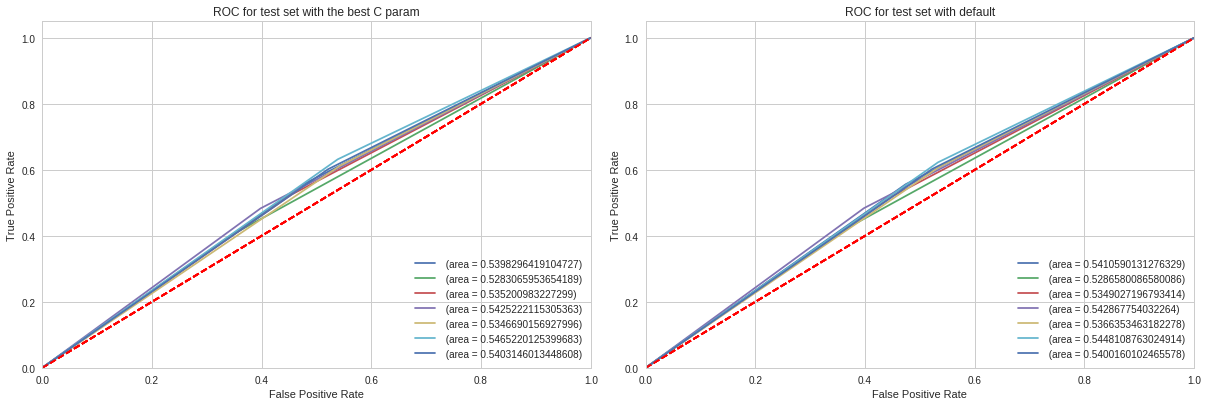

In [8]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['linear-default'] = np.zeros(len(stocks))
df_results['linear-tunned'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with default')
    df_results['linear-default'][s] = score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

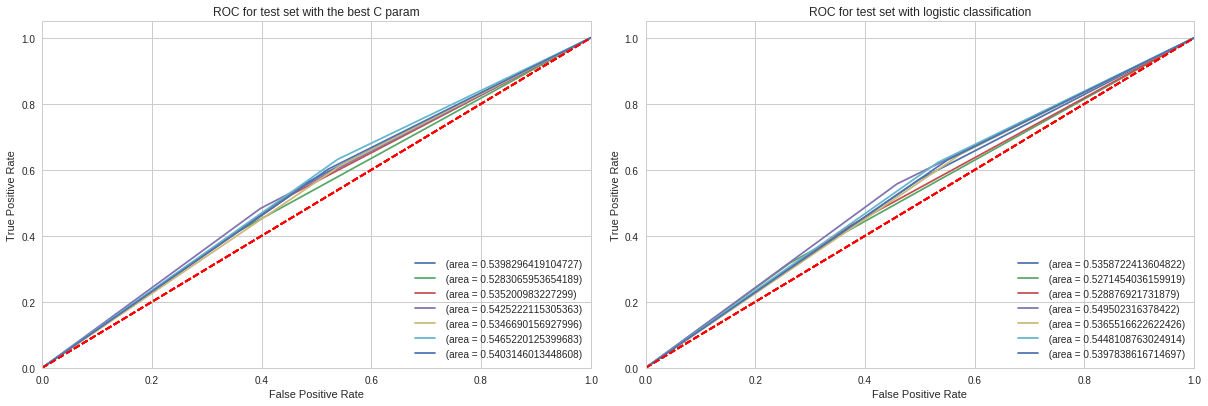

In [9]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    
    score = lob.plot_roc(dfs_test[s], reg_log, title='ROC for test set with logistic classification')
    df_results['logistic'][s] = score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [10]:
df_results

,logistic,linear-default,linear-tunned
9058,0.535872,0.541059,0.539830
13003,0.527145,0.528658,0.528307
9061,0.528877,0.534903,0.535201
9074,0.549502,0.542868,0.542522
11244,0.536552,0.536635,0.534669
9270,0.544811,0.544811,0.546522
9064,0.539784,0.540016,0.540315


# Conclusions